<h1><strong><u><font color='blue'>SafeCity : Multilabel Classification of Diverse Forms of Sexual Harrassment Personal Stories</font></u></strong></h1>

<h1><strong><font color='green'>Exploratoy Data Analysis </font></strong></h1>

In [ ]:
#Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy

In [ ]:
#Reading the csv files as pandas DataFrame
train=pd.read_csv('train.csv')
cv=pd.read_csv('dev.csv')
test=pd.read_csv('test.csv')
print('Shape of train data : ',train.shape)
print('Shape of cross-validation data : ',cv.shape)
print('Shape of test data : ',test.shape)

Shape of train data :  (7201, 4)
Shape of cross-validation data :  (990, 4)
Shape of test data :  (1701, 4)


In [ ]:
print('Datatypes of each feature column : \n')
train.dtypes

Datatypes of each feature column : 



Description                          object
Commenting                            int64
Ogling/Facial Expressions/Staring     int64
Touching /Groping                     int64
dtype: object

In [ ]:
train.head()

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [ ]:
duplicates = train[train.duplicated(subset='Description')]
print('Total duplicates found was : ',len(duplicates))

Total duplicates found was :  542


In [ ]:
len(train[train['Description']=='misbehaved'])

55

In [ ]:
train[train['Description']=='misbehaved']

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
180,misbehaved,1,0,0
199,misbehaved,0,0,1
367,misbehaved,0,0,0
460,misbehaved,0,0,0
790,misbehaved,1,0,0
884,misbehaved,0,0,0
965,misbehaved,0,0,1
1203,misbehaved,1,0,0
1505,misbehaved,0,0,1
1510,misbehaved,0,0,0


<p><b>Observations : </b>By checking the duplicates on a single description we can notice that many rows have been duplicated, this could have been happened while manual labeling of data where a single word is interpreted to fall into different categories in different circumstances.</p>
<p>To avoid this ambiguities we replace all the duplicates of a point with a single point having labels 1,1,1 </p>

In [ ]:
def remove_duplicates(data):
  data.drop_duplicates(keep='first',inplace=True)
  duplicates = data[data.duplicated(subset='Description',keep=False)]
  dup_indexes=list(duplicates.index)
  data_indexes=list(data.index)
  data_is_duplicated=map(lambda index: 1 if index in dup_indexes else 0,data_indexes)
  data['is_duplicate']=list(data_is_duplicated)
  data['Commenting']=data.apply(lambda row: 1 if row['is_duplicate']==1 else row['Commenting'],axis=1)
  data['Ogling/Facial Expressions/Staring']=data.apply(lambda row: 1 if row['is_duplicate']==1 else row['Ogling/Facial Expressions/Staring'],axis=1)
  data['Touching /Groping']=data.apply(lambda row: 1 if row['is_duplicate']==1 else row['Touching /Groping'],axis=1)
  data.drop_duplicates(inplace=True)
  data.drop(['is_duplicate'],axis=1,inplace=True)

In [ ]:
#Replacing the duplicates with 1,1,1

remove_duplicates(train)
remove_duplicates(cv)
remove_duplicates(test)

In [ ]:
print('All the duplicate rows are removed keeping a single rows with 1,1,1 labels')
train[train['Description']=='misbehaved']

All the duplicate rows are removed keeping a single rows with 1,1,1 labels


,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
180,misbehaved,1,1,1


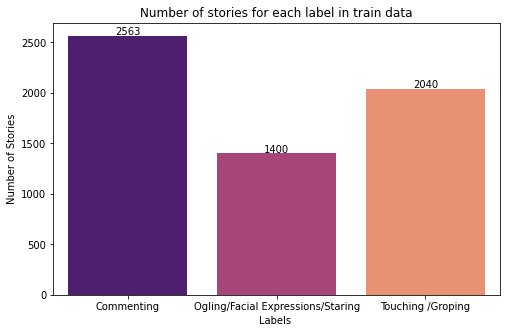

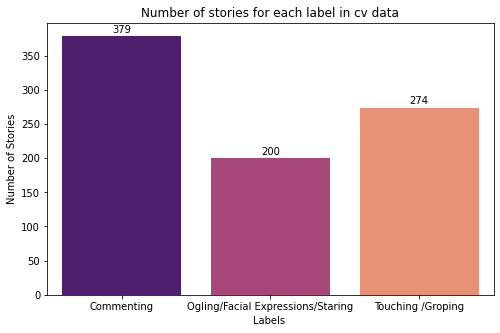

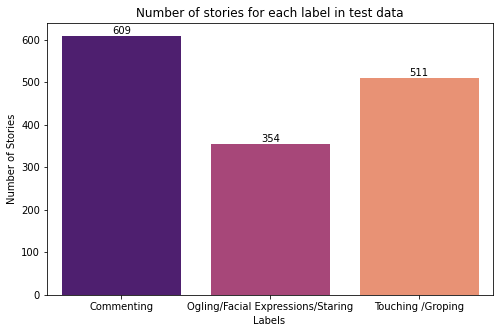

In [ ]:
labels = ['Commenting','Ogling/Facial Expressions/Staring','Touching /Groping'] #Labels for x-axis on plot
plt.figure(figsize=(8,5))
label_counts=train.iloc[:,1:].sum() # To get the total number of points with corresponding label
ax= sns.barplot(labels, label_counts,palette='magma')
for i in range(3):
  ax.text(x=i,y=label_counts[i]+10,s=label_counts[i],ha='center') # For numeric text on barplot
plt.title("Number of stories for each label in train data")
plt.ylabel('Number of Stories')
plt.xlabel('Labels ')
plt.show()

plt.figure(figsize=(8,5))
label_counts=cv.iloc[:,1:].sum()
ax= sns.barplot(labels, label_counts,palette='magma')
for i in range(3):
  ax.text(x=i,y=label_counts[i]+5,s=label_counts[i],ha='center')
plt.title("Number of stories for each label in cv data")
plt.ylabel('Number of Stories')
plt.xlabel('Labels ')
plt.show()

plt.figure(figsize=(8,5))
label_counts=test.iloc[:,1:].sum()
ax= sns.barplot(labels, label_counts,palette='magma')
for i in range(3):
  ax.text(x=i,y=label_counts[i]+5,s=label_counts[i],ha='center')
plt.title("Number of stories for each label in test data")
plt.ylabel('Number of Stories')
plt.xlabel('Labels ')
plt.show()

<p><b>Observations : </b>By observing the above plots of Number of stories vs labels we can conclude that the data was split evenly between train,cv and test datasets.</p>
<p>There was a little class imbalance that can be ignored.</p>

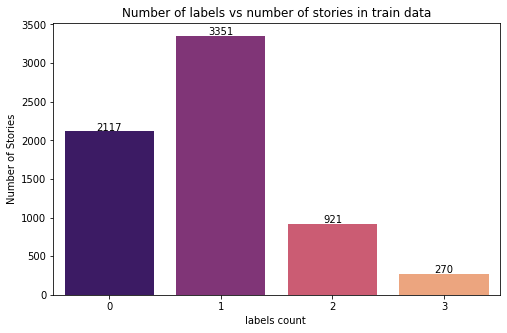

In [ ]:
no_of_labels = ['0','1','2','3']
plt.figure(figsize=(8,5))
value_counts=train.iloc[:,1:].sum(axis=1).value_counts() # Summing up to get number of labels for a given datapoint
no_of_points_perlabel=[value_counts[i] for i in range(4)] # Getting value counts for specific label count to match with x-axis for plotting
ax= sns.barplot(no_of_labels, no_of_points_perlabel,palette='magma')
for i in range(4):
  ax.text(x=i,y=no_of_points_perlabel[i]+10,s=no_of_points_perlabel[i],ha='center')
plt.title("Number of labels vs number of stories in train data")
plt.ylabel('Number of Stories')
plt.xlabel('labels count ')
plt.show()

<b><p>Observations : </b>By observing above plot showing the number of labels for datapoints, we can say :
<li>very less datapoints have assigned to all the 3 labels</li>
<li>Most of the points have assigned with one label followed by points with no labeling at all</li>
</p>

<h1><strong><font color='green'>Data preprocessing </font></strong></h1>

<p>we will do the following preprocessing on text data :</p>
<li>Dencontraction of words</li>
<li>Removing special characters</li>
<li>Stopwords removal</li>
<li>Stemming</li>

In [ ]:
def decontracted(text):
    '''Funtion to expand the sentences which are in short forms'''
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
def remove_special_chars(text):
  '''This function removes the special chars from the text'''
  text = re.sub('[^A-Za-z0-9]+', ' ', text)
  text=text.lower()
  return text

In [ ]:
nltk.download('stopwords')
stopWords=stopwords.words('english')
stemmer=SnowballStemmer('english')

#removing no,nor and not words from the english stopwords
stopWords.remove('not')
stopWords.remove('no')
stopWords.remove('nor')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(text):
  '''This function removes the stopwords from the text'''
  text=[word for word in text.split() if not word in stopWords]
  text=' '.join(text)
  return text

In [ ]:
def stemming(text):
  '''This function is to do stemming on words of text'''
  text=' '.join([stemmer.stem(word) for word in text.split()])
  return text

In [ ]:
#Creating a copies of original data
final_train=train.copy()
final_cv=cv.copy()
final_test=test.copy()

In [ ]:
def preprocess_text(text):
  '''This function does all the text preprocessing steps and return a clean text'''
  text=decontracted(text)
  text=remove_special_chars(text)
  text=remove_stopwords(text)
  text=stemming(text)
  return text

In [ ]:
#Preprocessing the text data of train,cv and test

final_train['Description']=final_train['Description'].apply(preprocess_text)
final_cv['Description']=final_cv['Description'].apply(preprocess_text)
final_test['Description']=final_test['Description'].apply(preprocess_text)

In [ ]:
def print_wordcloud(data,column):
  '''Printing word cloud on text data'''
  text=''
  for index,row in data.iterrows():
    if row[column]==1:
      text+=row['Description']+' '
  wc = WordCloud(stopwords=STOPWORDS,background_color="black",width=1000,height=800)
  wc.generate(text)
  plt.figure(figsize=(8,6))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title("Word Cloud for train text data on Class "+column,fontsize=20)
  plt.show()


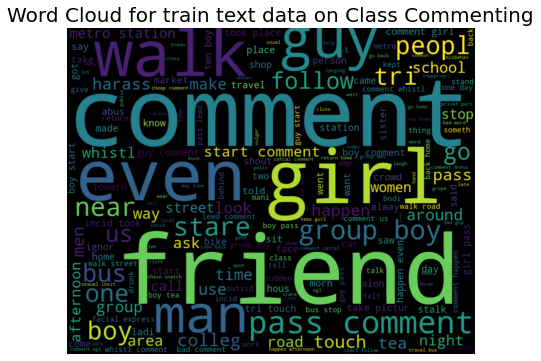

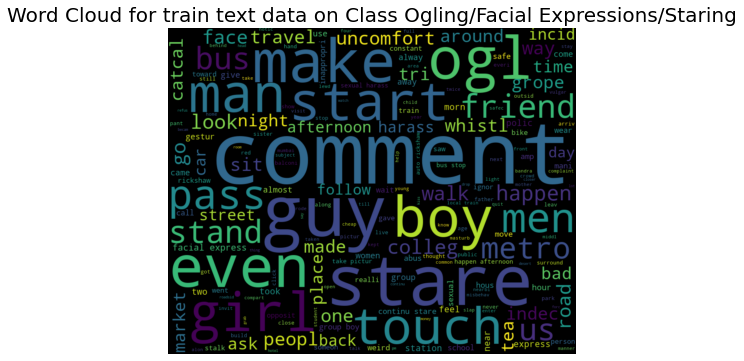

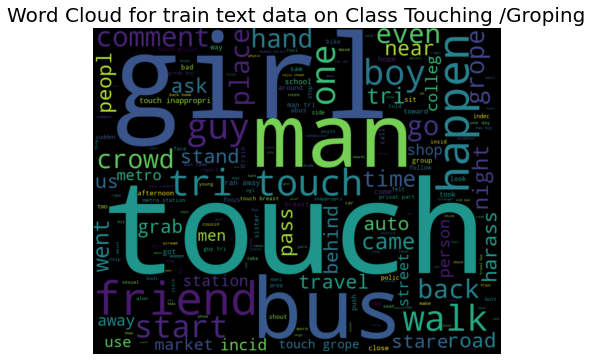

In [ ]:
print_wordcloud(final_train,'Commenting')
print_wordcloud(final_cv,'Ogling/Facial Expressions/Staring')
print_wordcloud(final_test,'Touching /Groping')

<p><b>Observation : </b> The wordcloud displays the words with high frequency in larger font. In general we can note that most of the words here are apparantly used while describing a specific sexual harassment story.</p>